In [1]:
### Benjamin Tollison ###
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import sympy as sp
import time
from IPython.display import Latex, Math, display
from sympy import (
    Eq,
    Function,
    Matrix,
    cos,
    cosh,
    exp,
    integrate,
    lambdify,
    pi,
    sin,
    sinh,
    symbols,
)
from decimal import Decimal
from sympy.solvers.pde import pdsolve
from sympy.solvers.solveset import linsolve
import ExponentialDecayModel as edm
def displayEquations(LHS,RHS):
    left = sp.latex(LHS)
    right = sp.latex(RHS)
    display(Math(left + '=' + right))
    np.set_printoptions(suppress=True)
def displayVariable(variable:str,RHS):
    left = sp.latex(symbols(variable))
    right = sp.latex(RHS)
    display(Math(left + '=' + right))
def displayVariableWithUnits(variable:str,RHS,units):
    left = sp.latex(symbols(variable))
    right = sp.latex(RHS)
    latexUnit = sp.latex(symbols(units))
    display(Math(left + '=' + right + '\\;' +'\\left['+ latexUnit + '\\right]'))
def format_scientific(number:float):
    a = '%E' % number
    return a.split('E')[0].rstrip('0').rstrip('.') + 'E' + a.split('E')[1]
deg2rad = np.pi/180
rad2deg = 180/np.pi
def timeit_decorator(func):
    def wrapper(*args, **kwargs):
        start_time = time.time()
        result = func(*args, **kwargs)
        end_time = time.time()
        execution_time = end_time - start_time
        print(f"{func.__name__} took {execution_time:.5f} seconds to run.")
        return result
    return wrapper

### 1)
 Given a helicopter of weight, $ W = 6000 \, \text{lb} $, calculate the power required in hover and at rates of climb ($ V_c $ ) of 300, 600, -300, and -600 ft/min. The radius of the main rotor is 21 ft and the rotor has a figure of merit of 0.75. Calculate your results at mean sea level conditions, and for density altitudes of five thousand and ten thousand feet. Plot your results in the form of power required versus climb velocity. Discuss the factors that will determine the \textbf{maximum vertical climb rate} of a helicopter.

For negative $ V_c $, check if $ -2 \leq \frac{V_c}{v_h} \leq 0 $. If yes, use the empirical relation below for calculating $ \frac{v_i}{v_h} $.

$$
\frac{v_i}{v_h} = \kappa + k_1 \left( \frac{V_c}{v_h} \right) + k_2 \left( \frac{V_c}{v_h} \right)^2 + k_3 \left( \frac{V_c}{v_h} \right)^3 + k_4 \left( \frac{V_c}{v_h} \right)^4
$$

with $k_1 = -1.125 $, $ k_2 = -1.372 $ ,$ k_3 = -1.718 $,  and $ k_4 = -0.655 $ Assume $ \kappa = 1 $

# Equations used to solve

$$W = \frac{6000 \, \text{lb}}{2.205} = m$$

$$
P_h = T_{\text{req}} v_i = \frac{T^{3/2}}{\sqrt{2 \rho A}} 
\qquad \left| \quad A = \pi r^2, \quad r = 21 \, \text{[ft]} \times 0.3048 \, \text{[m]} \right|
$$

$$
T_{\text{req}} = mg
$$

$$
\Rightarrow \quad P_h = \frac{P_{h,i} (\rho)}{FM}
$$

$$
P_{c,i} = T_{\text{req}} (v_c + v_i)
$$

$$
P_c = \frac{P_{c,i} (\rho, v_c)}{FM}
$$

$$
\frac{v_i}{v_h} = -\frac{v_c}{2 v_h} + \sqrt{\left(\frac{v_c}{2 v_h}\right)^2 + 1}
$$


In [2]:
ft2km = 0.000305
ft2m = 0.3048
mass = 6000 / 2.205
figure_of_merit = 0.75
thrust_req = mass * 9.81
density_sea_level, density_5k_ft, density_10k_ft = edm.Density(0), edm.Density(5000*ft2km), edm.Density(10000*ft2km)
density_list = [density_sea_level,density_5k_ft,density_10k_ft]
rotor_area = np.pi*(21*ft2m)**2
velocity_climb_list = [(ft2m/60)*i for i in [-600,-300,0,300,600]]
def PowerHover(density:float):
  power_ideal = thrust_req**1.5 / (2*density*rotor_area)**0.5
  return power_ideal/figure_of_merit
def VelocityHover(density:float):
  return (thrust_req / (2*density*rotor_area))**0.5
def NegativeVelocityInducedRatio(velocity_climb:float, velocity_hover:float):
  alef = velocity_climb/velocity_hover
  k1,k2,k3,k4 = -1.125,-1.372,-1.718,-0.655
  return 1 + k1*alef + k2*alef**2 + k3*alef**3 + k4*alef**4
def PowerClimb(velocity_climb:float,density:float):
  velocity_hover = VelocityHover(density)
  if velocity_climb/velocity_hover >= -2 and velocity_climb/velocity_hover <= 0:
    velocity_induced = NegativeVelocityInducedRatio(velocity_climb,velocity_hover)*velocity_hover
  else:
    alef = (-1/2)*(velocity_climb/(2*velocity_hover)) + ((velocity_climb/(2*velocity_hover))**2 + 1)**0.5
    velocity_induced = alef*velocity_hover
  power_climb_ideal = thrust_req*(velocity_climb + velocity_induced)
  return power_climb_ideal / figure_of_merit
# sanity check
displayVariable('v_h',VelocityHover(density_sea_level))
displayVariable('P_{c(v_c=0,\\rho=1.225)}',PowerClimb(0,density_sea_level))
displayVariable('P_h(v_c=0)',PowerHover(density_sea_level))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

,sea_level,5k,10k
0,309587.523820,347650.955681,389798.612630
1,324312.831175,361424.002900,402521.238559
2,327464.327358,363786.096301,404136.612161
3,369266.973064,405477.126429,445727.082650
4,413289.249616,449170.652123,489123.397163


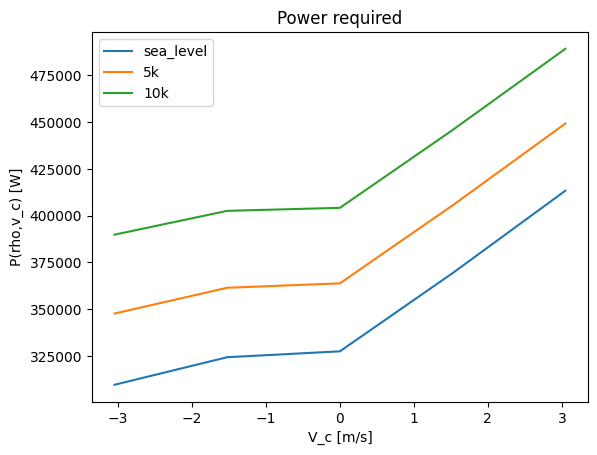

In [3]:
power_dict = {}
power_dict['sea_level'] = [PowerClimb(i,density_sea_level) for i in velocity_climb_list]
power_dict['5k'] = [PowerClimb(i,density_5k_ft) for i in velocity_climb_list]
power_dict['10k'] = [PowerClimb(i,density_10k_ft) for i in velocity_climb_list]
display(pd.DataFrame(power_dict))
for i in power_dict.keys():
  plt.plot(velocity_climb_list,power_dict[str(i)],label=i)
plt.title('Power required')
plt.xlabel('V_c [m/s]')
plt.ylabel('P(rho,v_c) [W]')
plt.legend()
plt.show()

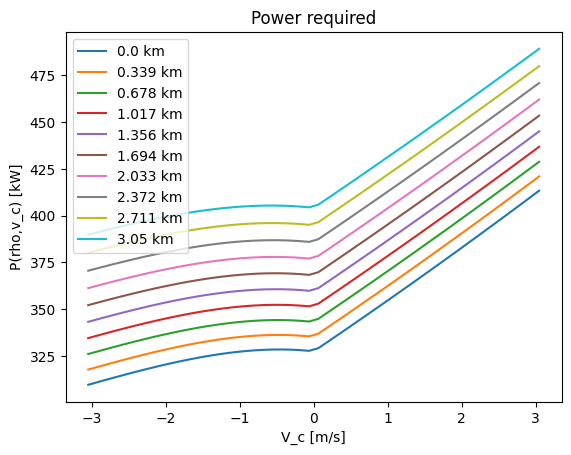

In [4]:
# making smoother curves
power_function_dict = {}
for altitude in np.linspace(0, 10000*ft2km, 10):
  power_function_dict[str(altitude)] = [PowerClimb(velocity,edm.Density(altitude))*10**-3 for velocity in np.linspace(velocity_climb_list[0],velocity_climb_list[-1],50)]
for i in power_function_dict.keys():
  plt.plot(np.linspace(velocity_climb_list[0],velocity_climb_list[-1],50),power_function_dict[i],label=f'{(round(float(i),3))} km')
plt.title('Power required')
plt.xlabel('V_c [m/s]')
plt.ylabel('P(rho,v_c) [kW]')
plt.legend()
plt.show()

### 2)
Starting from the momentum theory result for the induced flow at the rotor disk in forward flight, program numerical solutions to this inflow equation using both the fixed-point (FP) iterative method and the Newton-Raphson (NR) method. Compare your numerical results with the **exact analytic result** for the case where rotor disk angle of attack ($\alpha$) is zero. Plot analytic theory as a curve and numerical solution as discrete points with symbols. For both numerical methods, explore the effect of the initial guess for $\lambda$ on the results from the numerical solution. [Assume $C_T = 0.01$]

Using the same helicopter to for finding induced flow

$\textbf{Finding Analytic for } \alpha = 0$:

$$
\lambda = \mu \, \tan^2 \theta + \frac{C_T}{2 \sqrt{\mu^2 + x^2}}
$$

$$
2 x \left( \mu^2 + x^2 \right)^{\frac{1}{2}} - C_T = 0
$$

$$
\left( 4 x^2 \mu^2 + 4 x^4 \right)^{\frac{1}{2}} - C_T = 0
$$

$$
4 x^2 \mu^2 + 4 x^4 - C_T^2 = 0
$$

$$
4 x^4 + 4 \mu^2 x^2 - C_T^2 = 0
$$

$$
\frac{\chi}{2} = \frac{-4 \mu^2 \pm \sqrt{16 \mu^4 - 4(4)(-C_T^2)}}{8} = -\frac{1}{2} \mu^2 \pm \frac{1}{2} \sqrt{\mu^4 + C_T^2}
$$

$$
\chi = \pm \sqrt{\frac{\chi}{2}}
$$

$$
\Rightarrow \lambda \text{ has 4 solutions}
$$

Assuming we are flying forwards, there is one $\operatorname{Re}\{\lambda\} > 0$



In [5]:
lambda_i, mu, alpha, C_T = sp.symbols('\\lambda_i, \\mu, \\alpha, C_T')
objective_symbolic = mu*sp.tan(alpha) + C_T / (2*(mu**2+lambda_i**2)**0.5) - lambda_i
display(objective_symbolic)
objective_symbolic_prime = objective_symbolic.diff(lambda_i)
objective_symbolic_doubleprime = objective_symbolic.diff(lambda_i,2)
display(objective_symbolic_prime)
display(objective_symbolic_doubleprime)
coefficient_thrust = 0.01
velocity_tip = lambda rho: (thrust_req/(rho*rotor_area*coefficient_thrust))**0.5
displayVariableWithUnits('\\Omega{R}',velocity_tip(density_sea_level),'\\frac{m}{s}')
def AdvanceRatio(
  rotor_tip_velocity:float,
  freestream_velocity:float,
  angle_of_attack:float
)->float:
  v_tip = rotor_tip_velocity
  v_infty = freestream_velocity
  alpha = angle_of_attack
  mu = v_infty * np.cos(alpha) / v_tip
  return mu
mu_sea_level = AdvanceRatio(velocity_tip(density_sea_level),VelocityHover(density_sea_level)*10,0)
alef = np.array([-0.5 * mu_sea_level**2 + 0.5*(mu_sea_level**4 + coefficient_thrust**2)**0.5,
                -0.5 * mu_sea_level**2 - 0.5*(mu_sea_level**4 + coefficient_thrust**2)**0.5])
displayVariable('\\alef',alef)
inflow_zero = np.array([
  np.emath.sqrt(alef),
  -np.emath.sqrt(alef)
])
displayVariable('\\lambda_0',inflow_zero)
for i in inflow_zero.real:
  if i[0] > 0.0:
    displayVariable('\\lambda_{\\alpha=0}',i[0])

C_T/(2*(\lambda_i**2 + \mu**2)**0.5) - \lambda_i + \mu*tan(\alpha)

-0.5*C_T*\lambda_i/(\lambda_i**2 + \mu**2)**1.5 - 1

C_T*(1.5*\lambda_i**2/(\lambda_i**2 + \mu**2)**2.5 - 0.5/(\lambda_i**2 + \mu**2)**1.5)

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [6]:
ObjectiveFunction = lambdify((lambda_i,mu,alpha,C_T),objective_symbolic,'numpy')
ObjectiveFunction_prime = lambdify((lambda_i,mu,alpha,C_T),objective_symbolic_prime,'numpy')
ObjectiveFunction_doubleprime = lambdify((lambda_i,mu,alpha,C_T),objective_symbolic_doubleprime,'numpy')
inflow_0 = np.sqrt(coefficient_thrust / 2)
tolerance = 1e-12
max_iteration_count = 300
def FixedPoint(inflow_ratio,angle_of_attack,advanvce_ratio):
  mu = advanvce_ratio
  alpha = angle_of_attack
  lambda_i = inflow_ratio
  C_T_given = coefficient_thrust
  fixed_point_dict = {
    'error_i':[],
    'lambda_i':[],
    'step' : [],
    'lambda_i+1':[],
    'error_i+1':[]
  }
  iteration_count = 0
  while abs(ObjectiveFunction(lambda_i,mu,alpha,C_T_given)) > tolerance and iteration_count < max_iteration_count:
    iteration_count += 1
    fixed_point_dict['error_i'].append(abs(ObjectiveFunction(lambda_i,mu,alpha,C_T_given)))
    fixed_point_dict['lambda_i'].append(lambda_i)
    fixed_point_dict['step'].append(ObjectiveFunction(lambda_i,mu,alpha,C_T_given))
    lambda_i = lambda_i + ObjectiveFunction(lambda_i,mu,alpha,C_T_given)
    fixed_point_dict['lambda_i+1'].append(lambda_i)
    fixed_point_dict['error_i+1'].append(abs(ObjectiveFunction(lambda_i,mu,alpha,C_T_given)))
  return fixed_point_dict
def NewtonRaphson(inflow_ratio,angle_of_attack,advanvce_ratio):
  mu = advanvce_ratio
  alpha = angle_of_attack
  lambda_i = inflow_ratio
  C_T_given = coefficient_thrust
  newton_raphson_dict = {
    'error_i':[],
    'lambda_i':[],
    'step': [],
    'lambda_i+1':[],
    'error_i+1':[]
  }
  iteration_count = 0
  while abs(ObjectiveFunction(lambda_i,mu,alpha,C_T_given)) > tolerance and iteration_count < max_iteration_count:
    iteration_count += 1
    newton_raphson_dict['error_i'].append(abs(ObjectiveFunction(lambda_i,mu,alpha,C_T_given)))
    newton_raphson_dict['lambda_i'].append(lambda_i)
    newton_raphson_dict['step'].append(ObjectiveFunction(lambda_i,mu,alpha,C_T_given)/ObjectiveFunction_prime(lambda_i,mu,alpha,C_T_given))
    lambda_i = lambda_i - ObjectiveFunction(lambda_i,mu,alpha,C_T_given)/ObjectiveFunction_prime(lambda_i,mu,alpha,C_T_given)
    newton_raphson_dict['lambda_i+1'].append(lambda_i)
    newton_raphson_dict['error_i+1'].append(abs(ObjectiveFunction(lambda_i,mu,alpha,C_T_given)))
  return newton_raphson_dict
def HalleysMethod(inflow_ratio,angle_of_attack,advanvce_ratio):
  mu = advanvce_ratio
  alpha = angle_of_attack
  lambda_i = inflow_ratio
  C_T_given = coefficient_thrust
  halley_dict = {
    'error_i':[],
    'lambda_i':[],
    'step': [],
    'lambda_i+1':[],
    'error_i+1':[]
  }
  iteration_count = 0
  while abs(ObjectiveFunction(lambda_i,mu,alpha,C_T_given)) > tolerance and iteration_count < max_iteration_count:
    iteration_count += 1
    halley_dict['error_i'].append(abs(ObjectiveFunction(lambda_i,mu,alpha,C_T_given)))
    halley_dict['lambda_i'].append(lambda_i)
    f = ObjectiveFunction(lambda_i,mu,alpha,C_T_given)
    f_prime = ObjectiveFunction_prime(lambda_i,mu,alpha,C_T_given)
    f_doubleprime = ObjectiveFunction_doubleprime(lambda_i,mu,alpha,C_T_given)
    try:
      step_size = 2*f / (f_prime - np.emath.sqrt((f_prime**2 -f*f_doubleprime)).real)
    except RuntimeError:
      step_size = f/f_prime
    halley_dict['step'].append(step_size)
    lambda_i = lambda_i - step_size
    halley_dict['lambda_i+1'].append(lambda_i)
    halley_dict['error_i+1'].append(abs(ObjectiveFunction(lambda_i,mu,alpha,C_T_given)))
  return halley_dict
for i in inflow_zero.real:
  if i[0] > 0.0:
    displayVariable('\\lambda_{\\alpha=0}',i[0])
displayVariable('\\lambda_{i=0}',inflow_0)
print('Fixed Point iterations')
start_time = time.time()
display(pd.DataFrame(FixedPoint(inflow_0,0,mu_sea_level)))
displayVariable('\\lambda_{FP}',FixedPoint(inflow_0,0,mu_sea_level)['lambda_i+1'][-1])
end_time = time.time()
print(f"Took {end_time-start_time:.5f} seconds to run")
print('Newton-Raphson iterations')
start_time = time.time()
display(pd.DataFrame(NewtonRaphson(inflow_0,0,mu_sea_level)))
displayVariable('\\lambda_{NR}',NewtonRaphson(inflow_0,0,mu_sea_level)['lambda_i+1'][-1])
end_time = time.time()
print(f"Took {end_time-start_time:.5f} seconds to run")
print('Halley\'s Method iterations')
start_time = time.time()
display(pd.DataFrame(HalleysMethod(inflow_0,0,mu_sea_level)))
displayVariable('\\lambda_{HM}',HalleysMethod(inflow_0,0,mu_sea_level)['lambda_i+1'][-1])
end_time = time.time()
print(f"Took {end_time-start_time:.5f} seconds to run")

<IPython.core.display.Math object>

<IPython.core.display.Math object>

Fixed Point iterations


,error_i,lambda_i,step,lambda_i+1,error_i+1
0,6.367470e-02,0.070711,-6.367470e-02,0.007036,3.474234e-05
1,3.474234e-05,0.007036,3.474234e-05,0.007071,3.465010e-09
2,3.465010e-09,0.007071,-3.465010e-09,0.007071,3.464321e-13


<IPython.core.display.Math object>

Took 0.00539 seconds to run
Newton-Raphson iterations


,error_i,lambda_i,step,lambda_i+1,error_i+1
0,6.367470e-02,0.070711,6.361203e-02,0.007099,2.793357e-05
1,2.793357e-05,0.007099,2.793076e-05,0.007071,5.513840e-12
2,5.513840e-12,0.007071,5.513289e-12,0.007071,8.673617e-19


<IPython.core.display.Math object>

Took 0.00540 seconds to run
Halley's Method iterations


,error_i,lambda_i,step,lambda_i+1,error_i+1
0,0.063675,0.070711,0.063626,0.007085,1.426388e-05
1,0.000014,0.007085,0.000014,0.007071,7.188651e-13


<IPython.core.display.Math object>

Took 0.00666 seconds to run


Took 0.00184 seconds to run analytical solution
Took 0.13015 seconds to run FP solution
Took 0.02534 seconds to run NR solution
Took 0.04688 seconds to run Halley's solution


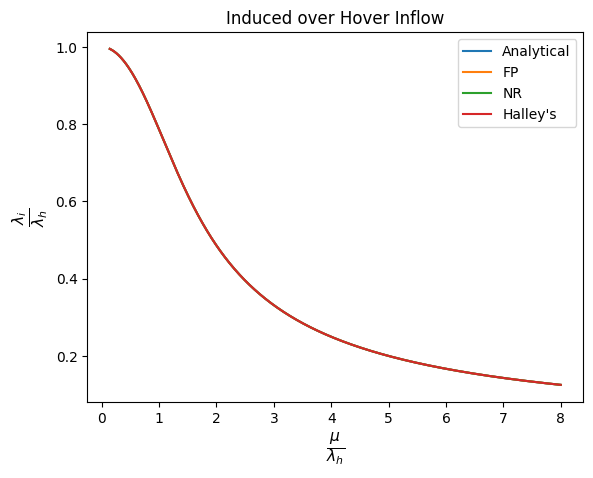

In [7]:
### analytical inflow ratio
inflow_hover = np.sqrt(coefficient_thrust/2)
def AnalyticalInflowRatio(advance_ratio,inflow_hover):
  variable_ratio = advance_ratio/inflow_hover
  return np.sqrt(-0.5*variable_ratio**2 + np.sqrt(0.25*variable_ratio**4 + 1))
advance_ratio_values = np.linspace(0.01,inflow_hover*8,1000)
start_time = time.time()
analytical_inflow_ratio_values = [AnalyticalInflowRatio(float(i),inflow_hover) for i in advance_ratio_values]
end_time = time.time()
analytical_runtime = end_time-start_time
print(f"Took {end_time-start_time:.5f} seconds to run analytical solution")
start_time = time.time()
fixed_point_inflow_ratio_values = [FixedPoint(inflow_0,0,float(i))['lambda_i+1'][-1]/inflow_hover for i in advance_ratio_values]
end_time = time.time()
fixed_point_runtime = end_time-start_time
print(f"Took {end_time-start_time:.5f} seconds to run FP solution")
start_time = time.time()
newton_raphson_inflow_ratio_values = [NewtonRaphson(inflow_0,0,float(i))['lambda_i+1'][-1]/inflow_hover for i in advance_ratio_values]
end_time = time.time()
newton_raphson_runtime = end_time-start_time
print(f"Took {end_time-start_time:.5f} seconds to run NR solution")
start_time = time.time()
halley_inflow_ratio_values = [HalleysMethod(inflow_0,0,float(i))['lambda_i+1'][-1]/inflow_hover for i in advance_ratio_values]
end_time = time.time()
halley_runtime = end_time-start_time
print(f"Took {end_time-start_time:.5f} seconds to run Halley\'s solution")



# plotting
input_ratio = advance_ratio_values/inflow_hover
plt.plot(input_ratio,analytical_inflow_ratio_values,label='Analytical')
plt.plot(input_ratio,fixed_point_inflow_ratio_values,label='FP')
plt.plot(input_ratio,newton_raphson_inflow_ratio_values,label='NR')
plt.plot(input_ratio,halley_inflow_ratio_values,label='Halley\'s')
plt.legend()
plt.title('Induced over Hover Inflow')
plt.xlabel(r'$ \frac{\mu}{\lambda_h} $',fontsize=16)
plt.ylabel(r'$ \frac{\lambda_i}{\lambda_h} $',fontsize=16)
plt.show()

# runtimes = [analytical_runtime,fixed_point_runtime,newton_raphson_runtime,halley_runtime]
# plt.hist(runtimes[1:],bins=3,edgecolor='black')
# plt.show()

3. Using the numerical solution in Q.2, perform the following tasks:

	- **Plot graphs of inflow ratio and induced inflow ratio versus advance ratio in level flight** for a series of rotor angles of attack (α).
		- Use both **positive and negative angles of attack** (vary α from -4° to 8° in 2° increments).

	- **Explore the effect of the initial guess for λ on the numerical solution**, and suggest why a single unique initial condition may not always be adequate.
		- Use both **Fixed-Point (FP)** and **Newton-Raphson (NR)** methods.

	- **Comment on your results** based on the plots and analysis.

Given $C_T$:

$$
C_T = \frac{T}{\rho (\Omega R)^2} \Rightarrow \Omega R = \sqrt{\frac{T}{\rho C_T}}
$$

$$
\mu = \mu (V_\infty, \alpha) = \frac{V_\infty \cos \alpha}{\Omega R}
$$

$$
V_\infty := 10 \, \nu_h (\rho)
$$

$$
\lambda = \mu \tan \alpha + \frac{C_T}{2(\mu^2 + \lambda^2)^{\frac{1}{2}}}
$$
# Numerics
### Objective Function $\lambda (\lambda, \alpha, \mu)$:

$$
f = \mu \tan \alpha + \frac{C_T}{2(\mu^2 + \lambda^2)^{\frac{1}{2}}} \lambda - \lambda
$$

### Fixed Point $(\lambda, \alpha, \mu)$:

$$
\lambda_{i+1} = \mu \tan \alpha + \frac{C_T}{2(\mu^2 + \lambda_i^2)^{\frac{1}{2}}}
$$

$$
\lambda_0 = \lambda = \sqrt{\frac{C_T}{2}}
$$

### Newton-Raphson $(\lambda, \alpha, \mu)$:

Define $\delta$ as:

$$
\delta = \frac{f}{f'} 
$$
$$ f= \text{Obj Func} (\lambda, \alpha, \mu)
$$

First derivative:

$$
f' = -\frac{C_T}{2} \left( \mu^2 + \lambda_i^2 \right)^{-\frac{3}{2}} \lambda_i - 1
$$

Iteration step:

$$
\lambda_{i+1} = \lambda_i - \delta
$$

### Halley's Method $(\lambda, \alpha, \mu)$:

Define $f$ as:

$$
f = \text{Obj Function} (\lambda, \alpha, \mu)
$$

First derivative:

$$
f' = -\frac{C_T}{2} \left( \mu^2 + \lambda_i^2 \right)^{-\frac{3}{2}} \lambda_i - 1
$$

Second derivative:

$$
f'' = \frac{3 C_T}{2} (\mu^2 + \lambda_i^2)^{-\frac{5}{2}} \lambda_i^2 - \frac{C_T}{2} (\mu^2 + \lambda_i^2)^{-\frac{3}{2}}
$$

Iteration step:

$$
\lambda_{i+1} = \lambda_i - \frac{2 f}{f' \pm \sqrt{f'^2 - 2 \delta f''}}
$$


In [8]:
def DoAllOfQuestion3(inital_inflow_guess):
  angle_of_attack_values = range(-4,9,2)
  start_time = time.time()
  fixed_point_func_mu = {}
  num_of_iterations_FP = []
  num_of_iterations_NR = []
  num_of_iterations_HM = []
  for alpha in angle_of_attack_values:
    fixed_point_func_mu[f'{alpha}'] =  [(FixedPoint(inital_inflow_guess,alpha*deg2rad,mu)['lambda_i+1']) for mu in advance_ratio_values]
    for lambda_i in fixed_point_func_mu[f'{alpha}']:
      num_of_iterations_FP.append(len(lambda_i))
  end_time = time.time()
  fixed_point_runtime = end_time - start_time
  print(f"Took {end_time-start_time:.5f} seconds to run FP solution")
  print(f"Average Rate of Convergence: {round(np.mean(num_of_iterations_FP),4)}")
  start_time = time.time()
  newton_raphson_func_mu = {}
  for alpha in angle_of_attack_values:
    newton_raphson_func_mu[f'{alpha}'] =  [(NewtonRaphson(inital_inflow_guess,alpha*deg2rad,mu)['lambda_i+1']) for mu in advance_ratio_values]
    for lambda_i in newton_raphson_func_mu[f'{alpha}']:
      num_of_iterations_NR.append(len(lambda_i))
  end_time = time.time()
  newton_runtime = end_time - start_time
  print(f"Took {end_time-start_time:.5f} seconds to run NR solution")
  print(f"Average Rate of Convergence: {round(np.mean(num_of_iterations_NR),4)}")
  halley_func_mu = {}
  for alpha in angle_of_attack_values:
    halley_func_mu[f'{alpha}'] =  [(HalleysMethod(inital_inflow_guess,alpha*deg2rad,mu)['lambda_i+1']) for mu in advance_ratio_values]
    for lambda_i in halley_func_mu[f'{alpha}']:
      num_of_iterations_HM.append(len(lambda_i))
  end_time = time.time()
  halley_runtime = end_time - start_time
  print(f"Took {end_time-start_time:.5f} seconds to run Halley solution")
  print(f"Average Rate of Convergence: {round(np.mean(num_of_iterations_HM),4)}")
  # Plotting  
  fig,axis = plt.subplots(int(len(angle_of_attack_values)/2+1),2, figsize=(10,8))
  axis[0,0].set_title(r'$ \alpha= -4 $')
  axis[0,0].plot(advance_ratio_values,[float(i[-1]) for i in fixed_point_func_mu['-4']],label='FP')
  axis[0,0].plot(advance_ratio_values,[float(i[-1]) for i in newton_raphson_func_mu['-4']],label='NR')
  axis[0,0].plot(advance_ratio_values,[float(i[-1]) for i in halley_func_mu['-4']],label='HM')
  axis[0,0].legend()
  axis[0,0].set_ylabel(r'$ \lambda_i $')
  axis[0,0].set_xlabel(r'$ \mu $')

  axis[0,1].set_title(r'$ \alpha= -2 $')
  axis[0,1].plot(advance_ratio_values,[float(i[-1]) for i in fixed_point_func_mu['-2']],label='FP')
  axis[0,1].plot(advance_ratio_values,[float(i[-1]) for i in newton_raphson_func_mu['-2']],label='NR')
  axis[0,1].plot(advance_ratio_values,[float(i[-1]) for i in halley_func_mu['-2']],label='HM')
  axis[0,1].legend()
  axis[0,1].set_ylabel(r'$ \lambda_i $')
  axis[0,1].set_xlabel(r'$ \mu $')

  axis[1,0].set_title(r'$ \alpha= 0 $')
  axis[1,0].plot(advance_ratio_values,[float(i[-1]) for i in fixed_point_func_mu['0']],label='FP')
  axis[1,0].plot(advance_ratio_values,[float(i[-1]) for i in newton_raphson_func_mu['0']],label='NR')
  axis[1,0].plot(advance_ratio_values,[float(i[-1]) for i in halley_func_mu['0']],label='HM')
  axis[1,0].legend()
  axis[1,0].set_ylabel(r'$ \lambda_i $')
  axis[1,0].set_xlabel(r'$ \mu $')

  axis[1,1].set_title(r'$ \alpha= 2 $')
  axis[1,1].plot(advance_ratio_values,[float(i[-1]) for i in fixed_point_func_mu['2']],label='FP')
  axis[1,1].plot(advance_ratio_values,[float(i[-1]) for i in newton_raphson_func_mu['2']],label='NR')
  axis[1,1].plot(advance_ratio_values,[float(i[-1]) for i in halley_func_mu['2']],label='HM')
  axis[1,1].legend()
  axis[1,1].set_ylabel(r'$ \lambda_i $')
  axis[1,1].set_xlabel(r'$ \mu $')

  axis[2,0].set_title(r'$ \alpha= 4 $')
  axis[2,0].plot(advance_ratio_values,[float(i[-1]) for i in fixed_point_func_mu['4']],label='FP')
  axis[2,0].plot(advance_ratio_values,[float(i[-1]) for i in newton_raphson_func_mu['4']],label='NR')
  axis[2,0].plot(advance_ratio_values,[float(i[-1]) for i in halley_func_mu['4']],label='HM')
  axis[2,0].legend()
  axis[2,0].set_ylabel(r'$ \lambda_i $')
  axis[2,0].set_xlabel(r'$ \mu $')

  axis[2,1].set_title(r'$ \alpha= 6 $')
  axis[2,1].plot(advance_ratio_values,[float(i[-1]) for i in fixed_point_func_mu['6']],label='FP')
  axis[2,1].plot(advance_ratio_values,[float(i[-1]) for i in newton_raphson_func_mu['6']],label='NR')
  axis[2,1].plot(advance_ratio_values,[float(i[-1]) for i in halley_func_mu['6']],label='HM')
  axis[2,1].legend()
  axis[2,1].set_ylabel(r'$ \lambda_i $')
  axis[2,1].set_xlabel(r'$ \mu $')

  axis[3,0].set_title(r'$ \alpha= 8 $')
  axis[3,0].plot(advance_ratio_values,[float(i[-1]) for i in fixed_point_func_mu['8']],label='FP')
  axis[3,0].plot(advance_ratio_values,[float(i[-1]) for i in newton_raphson_func_mu['8']],label='NR')
  axis[3,0].plot(advance_ratio_values,[float(i[-1]) for i in halley_func_mu['8']],label='HM')
  axis[3,0].legend()
  axis[3,0].set_ylabel(r'$ \lambda_i $')
  axis[3,0].set_xlabel(r'$ \mu $')

  axis[3,1].set_title('Convergence NR v HM')
  axis[3,1].plot(np.arange(0,len(num_of_iterations_NR)),num_of_iterations_NR,label='NR')
  axis[3,1].plot(np.arange(0,len(num_of_iterations_HM)),num_of_iterations_HM,label='HM')
  axis[3,1].legend()
  axis[3,1].set_xlabel(r'$ \beta $')
  axis[3,1].set_ylabel(r'$ iterations $')

  fig.suptitle(r'$ \lambda_{i=0}  =$' + f'{round(inital_inflow_guess,4)}')
  plt.tight_layout()
  plt.show()
  
  fig2,axis2 = plt.subplots(3,1,figsize=(8,10))
  for alpha in angle_of_attack_values:
    axis2[0].plot(advance_ratio_values,[float(i[-1]) for i in fixed_point_func_mu[f'{alpha}']],label=f'{alpha}')
    axis2[1].plot(advance_ratio_values,[float(i[-1]) for i in newton_raphson_func_mu[f'{alpha}']],label=f'{alpha}')
    axis2[2].plot(advance_ratio_values,[float(i[-1]) for i in halley_func_mu[f'{alpha}']],label=f'{alpha}')
  axis2[0].set_title('Fixed Point')
  axis2[0].legend()
  axis2[0].set_ylabel(r'$ \lambda_i $')
  axis2[0].set_xlabel(r'$ \mu $')
  axis2[1].set_title('Newton Raphson')
  axis2[1].legend()
  axis2[1].set_ylabel(r'$ \lambda_i $')
  axis2[1].set_xlabel(r'$ \mu $')
  axis2[2].set_title('Halley Method')
  axis2[2].legend()
  axis2[2].set_ylabel(r'$ \lambda_i $')
  axis2[2].set_xlabel(r'$ \mu $')
  plt.tight_layout(h_pad=1.0)
  plt.show()
  
  return None

Took 0.73229 seconds to run FP solution
Average Rate of Convergence: 17.9064
Took 0.22161 seconds to run NR solution
Average Rate of Convergence: 2.8931
Took 0.51599 seconds to run Halley solution
Average Rate of Convergence: 2.8443


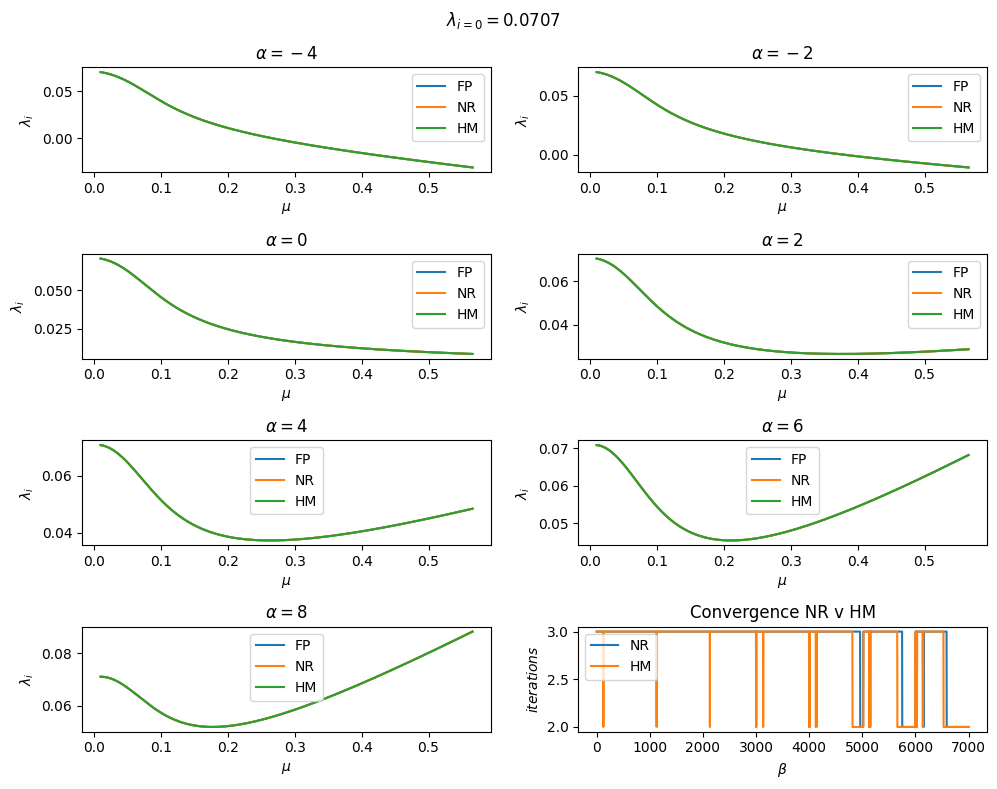

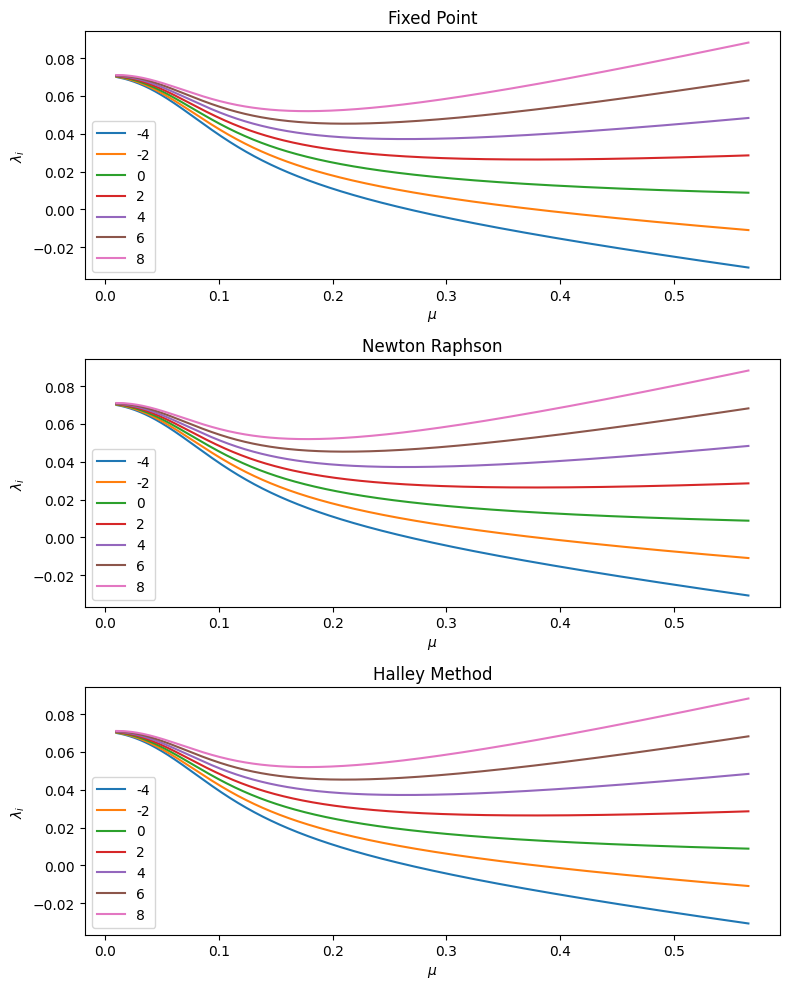

In [9]:
DoAllOfQuestion3(inflow_hover)

Took 0.80078 seconds to run FP solution
Average Rate of Convergence: 19.5404
Took 0.17612 seconds to run NR solution
Average Rate of Convergence: 3.3513
Took 0.59459 seconds to run Halley solution
Average Rate of Convergence: 3.3414


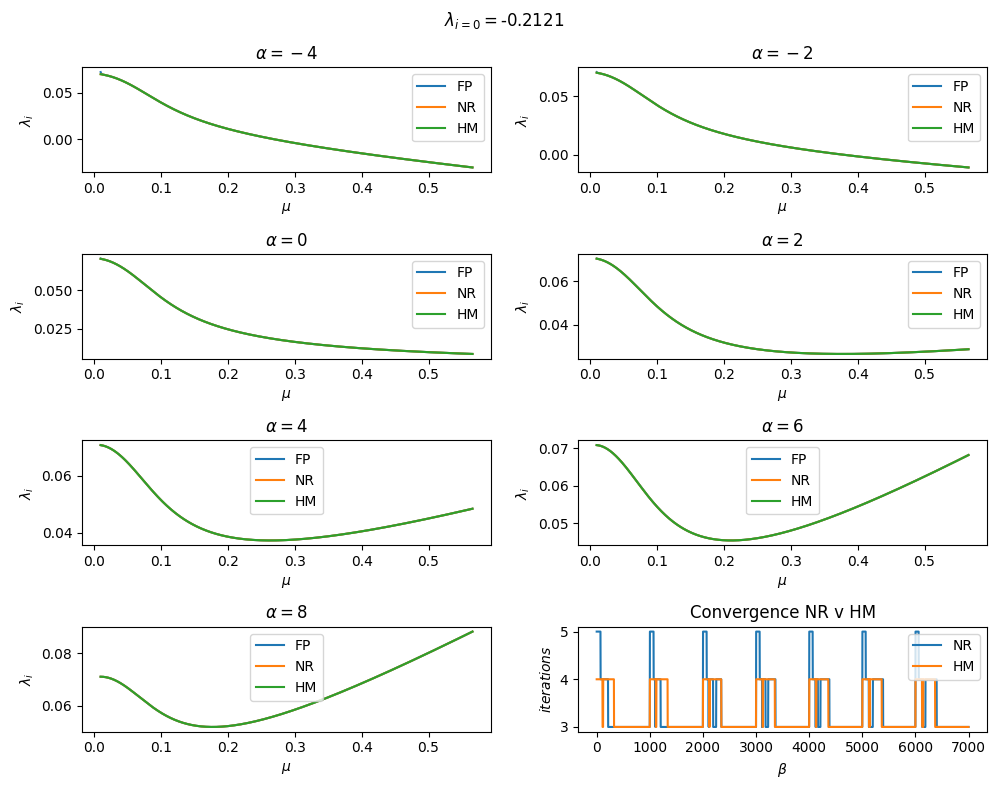

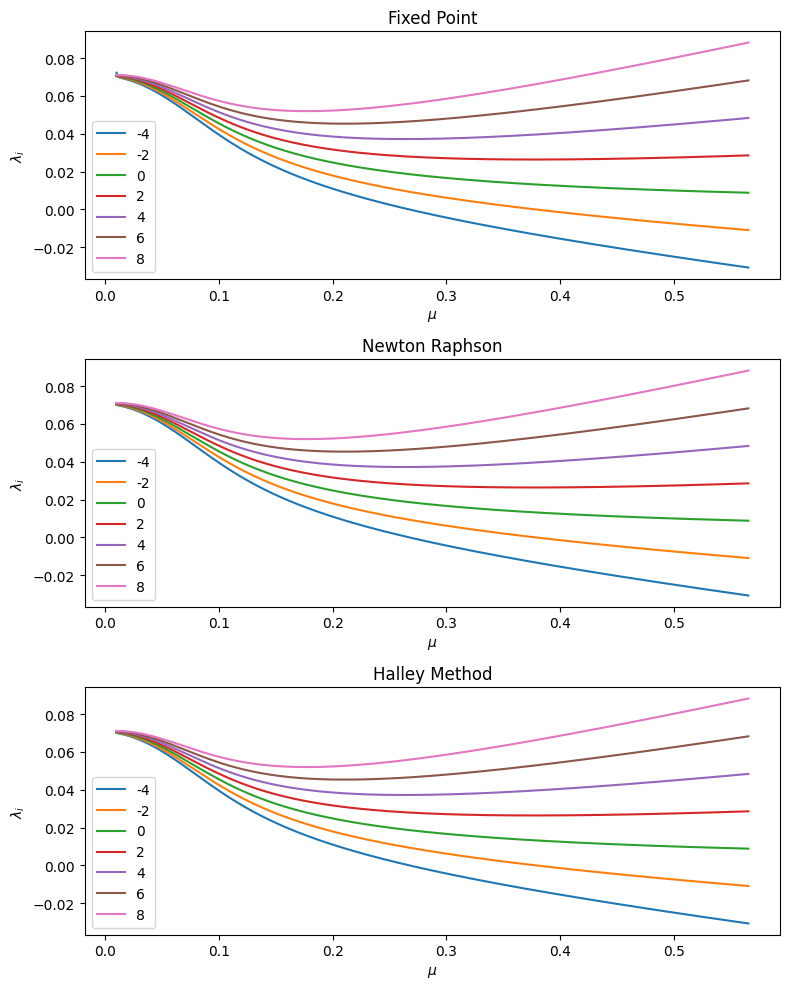

Took 0.80704 seconds to run FP solution
Average Rate of Convergence: 19.2521
Took 0.18182 seconds to run NR solution
Average Rate of Convergence: 3.4976
Took 0.53118 seconds to run Halley solution
Average Rate of Convergence: 3.5047


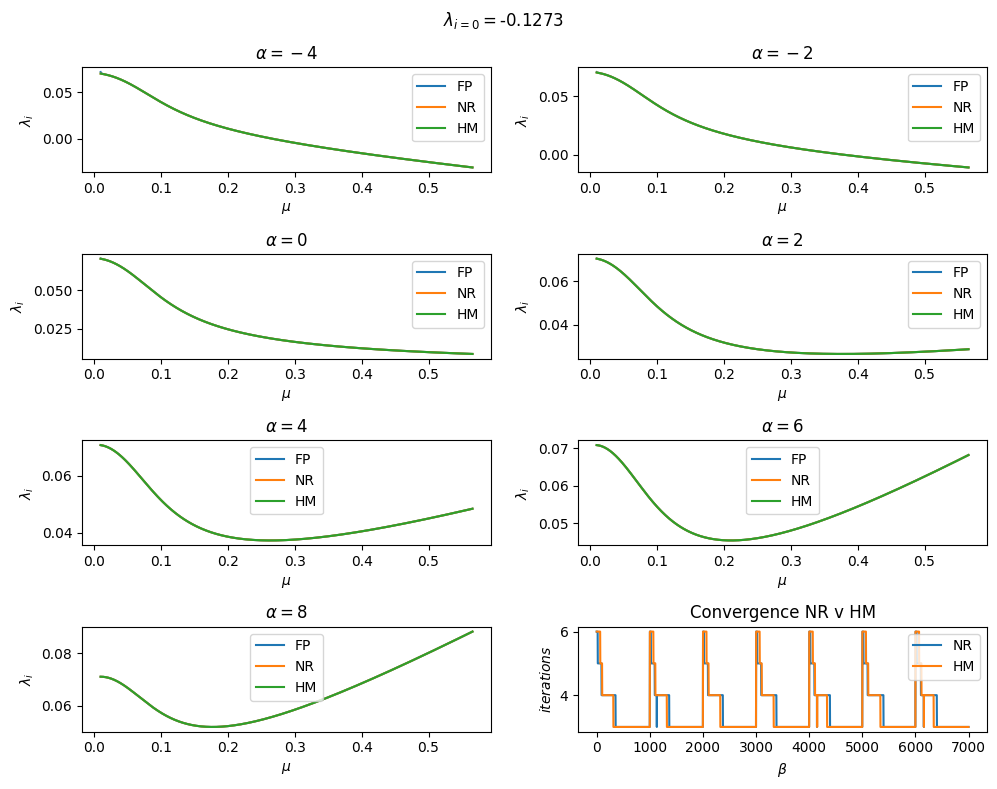

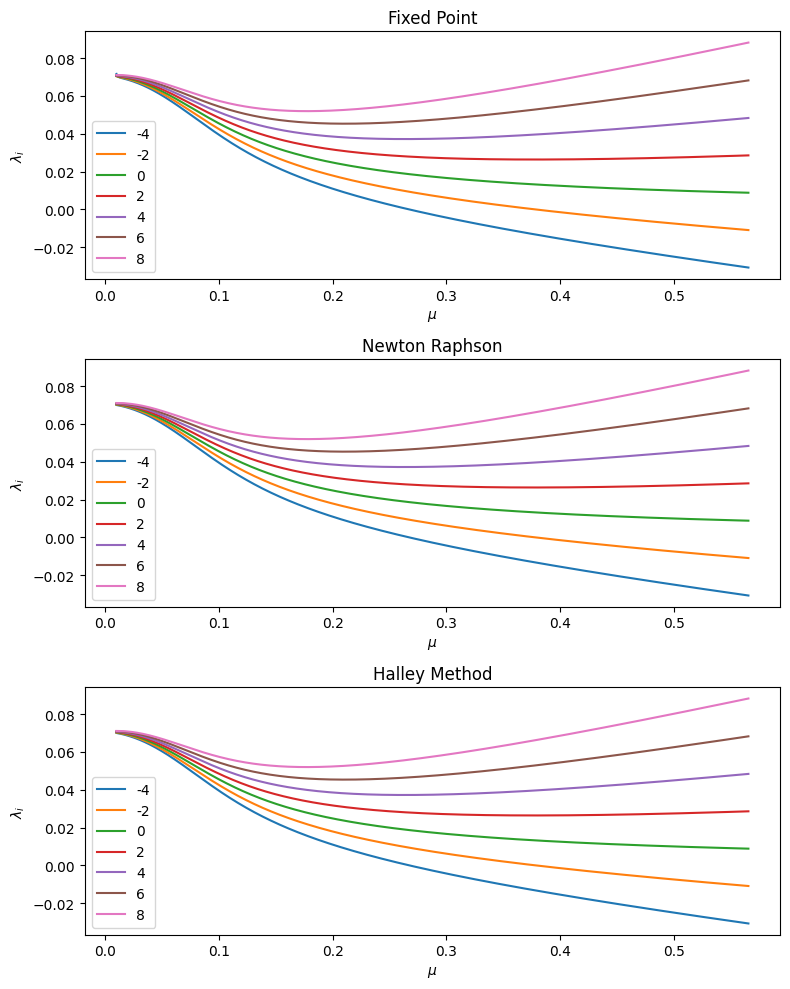

Took 0.80069 seconds to run FP solution
Average Rate of Convergence: 18.5857
Took 0.17444 seconds to run NR solution
Average Rate of Convergence: 3.4893
Took 0.51748 seconds to run Halley solution
Average Rate of Convergence: 3.3899


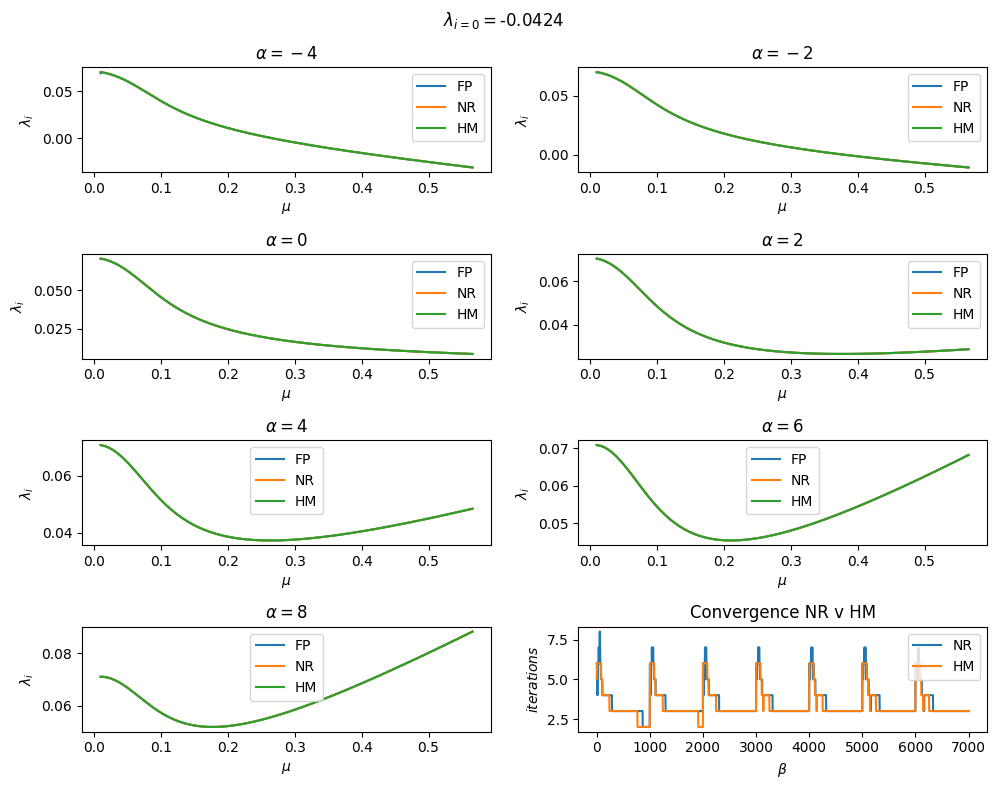

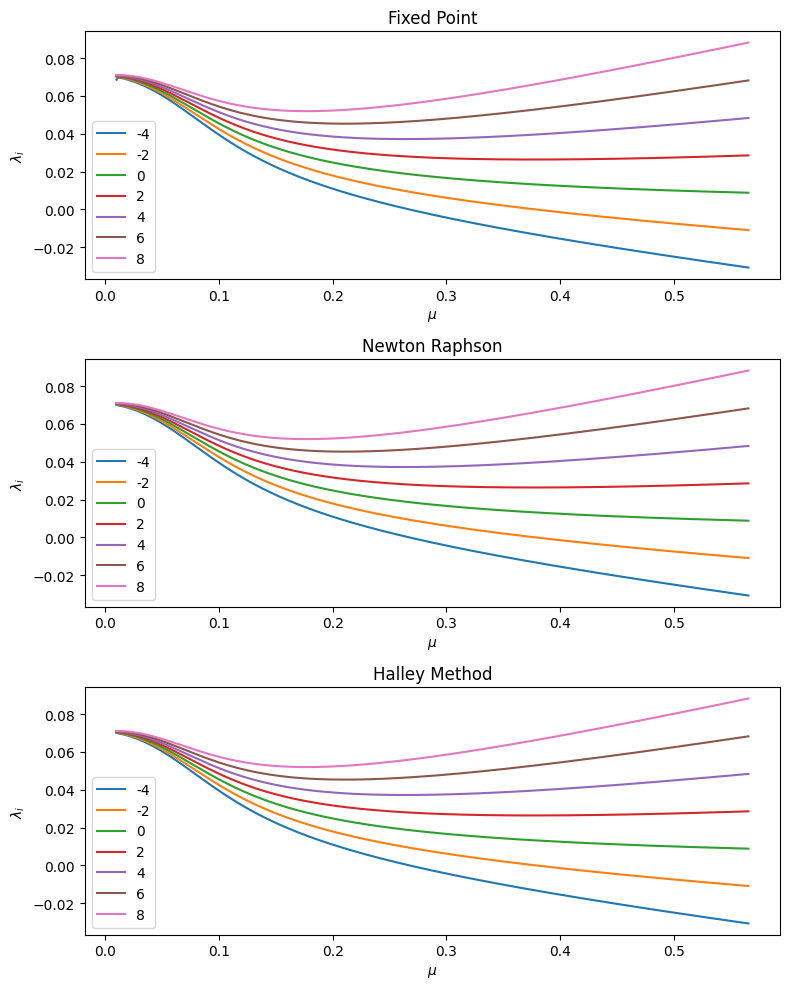

Took 0.79334 seconds to run FP solution
Average Rate of Convergence: 18.5857
Took 0.14071 seconds to run NR solution
Average Rate of Convergence: 2.9291
Took 0.44137 seconds to run Halley solution
Average Rate of Convergence: 2.7734


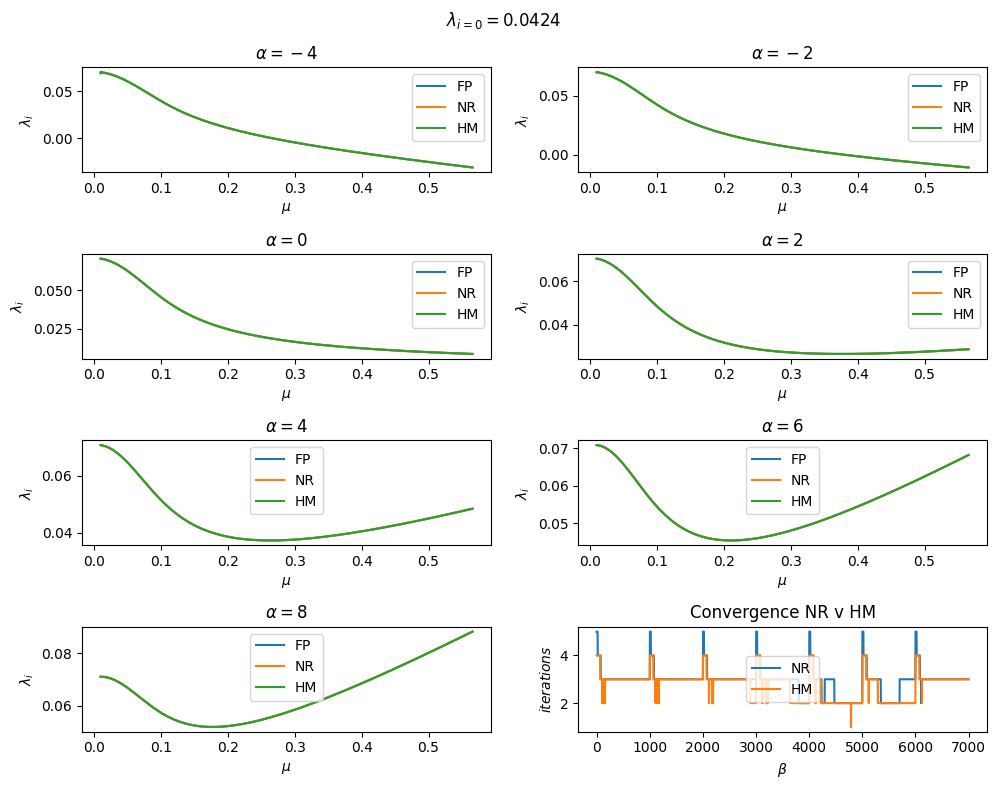

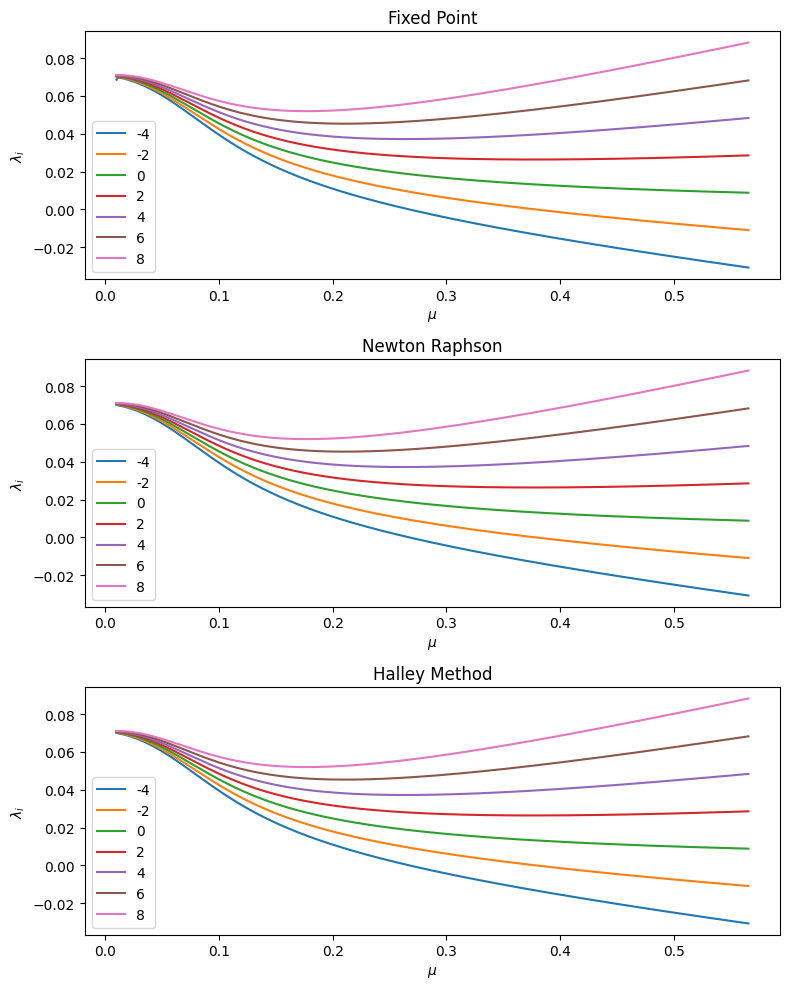

Took 1.07009 seconds to run FP solution
Average Rate of Convergence: 19.2521
Took 0.17646 seconds to run NR solution
Average Rate of Convergence: 3.2149
Took 0.54852 seconds to run Halley solution
Average Rate of Convergence: 3.1024


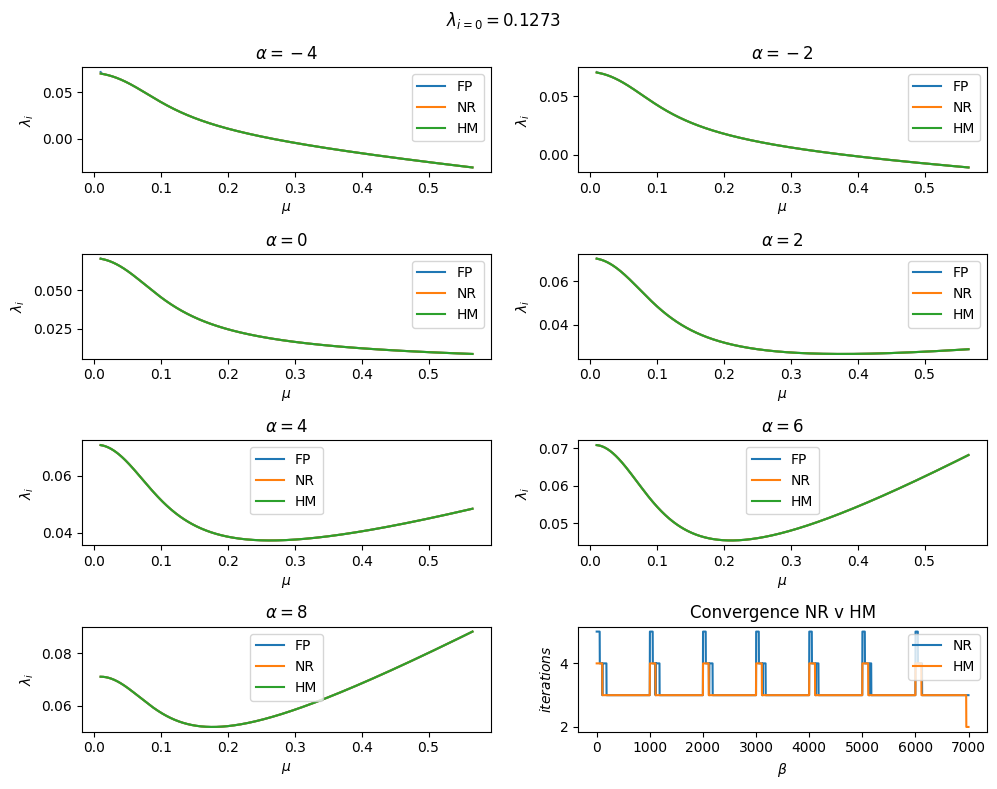

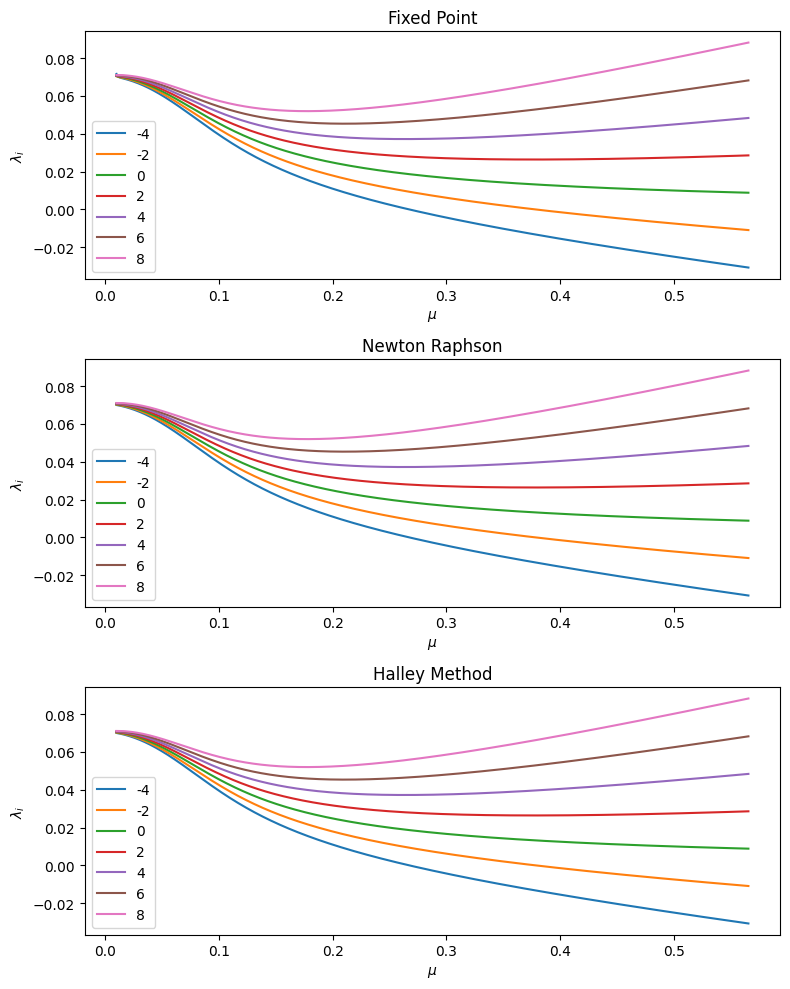

Took 0.77259 seconds to run FP solution
Average Rate of Convergence: 19.5404
Took 0.16108 seconds to run NR solution
Average Rate of Convergence: 3.3641
Took 0.48776 seconds to run Halley solution
Average Rate of Convergence: 3.259


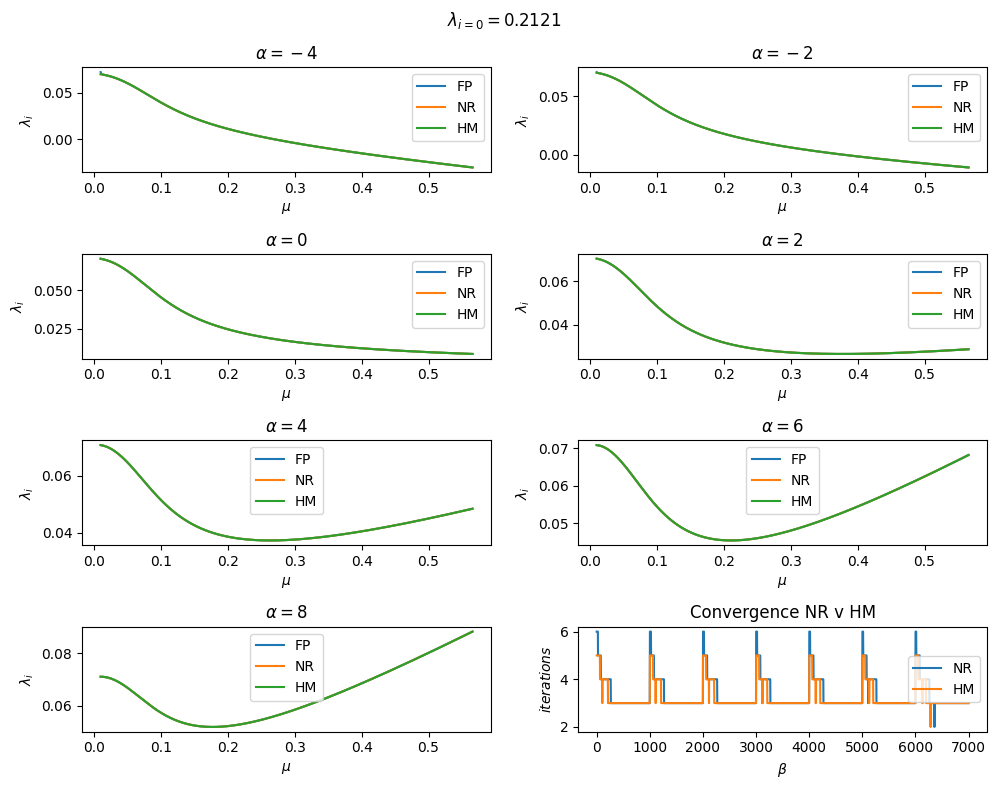

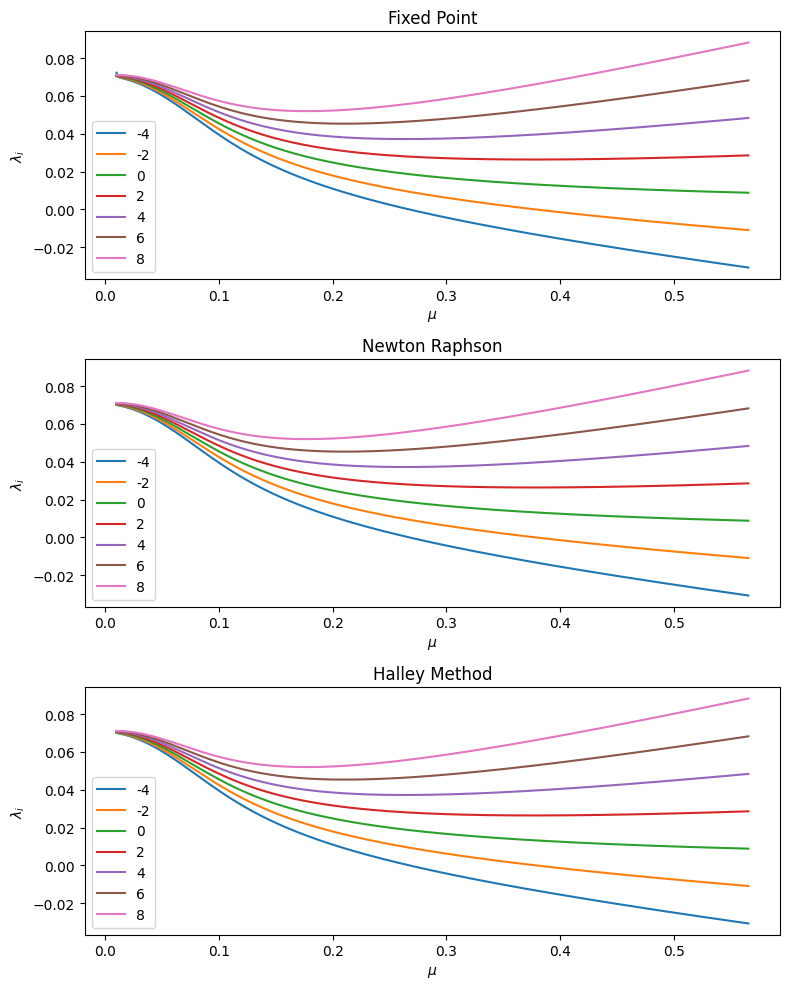

In [10]:
scaling_factor = 3
inital_inflow_guess_values = np.linspace(-scaling_factor*inflow_hover,scaling_factor*inflow_hover,6)
for i in inital_inflow_guess_values:
  DoAllOfQuestion3(i)

- All three numerical schemes demonstrate a high level of stability, regardless of the starting guess.

- Halley's Method converges in slightly fewer iterations compared to the Newton-Raphson Method on average.

- The Newton-Raphson Method is less complex to calculate in each iteration, which is why it runs faster.

- A potential way to speed up all methods would be to retain the last converged value and use it as the initial guess for following calculations

### 4)
Compare the results from the iterative solution of the general inflow equation to the exact
analytical inflow equation for the case of axial climbing and descending flight.
Numerically, reconstruct the complete induced velocity curve and the universal power
curve, and compare with the exact (analytic) results derived in class. Plot the analytic
theory as a curve and numerical solution as discrete points with symbols. Use both FP and
NR methods to solve the inflow equation. Determine the conditions (if any) under which
these methods may fail or give unexpected results.

$$
\lambda = \mu \tan \alpha + \frac{C_T}{2 \sqrt{\mu^2 + \lambda^2}} + \frac{V_i}{\Omega R} \cos \alpha
$$

Where:

$$
\frac{\lambda_i}{\lambda_h} \text{ vs. } \frac{V_i}{V_h} \quad \& \quad \frac{P}{P_h} \text{ vs. } \frac{\lambda_c}{\lambda_h}
$$

$$
\frac{V_i}{V_h} = \frac{V_\infty}{V_h} \Rightarrow \frac{V_\infty}{V_h} \in [-2, 0]
$$

For axial conditions where $\mu = 0$ and $\alpha = 0$:

$$
\lambda = \frac{C_T}{2 \sqrt{\lambda_i^2 + \lambda_h}} + \lambda_c
$$

Approximate expression for $\frac{\lambda_i}{\lambda_h}$:

$$
\frac{\lambda_i}{\lambda_h} \approx \frac{1}{2 \lambda_h} \cdot C_T - \frac{\lambda_c}{\lambda_h}
$$


### Objective Function

$$
\text{Obj Func} = \frac{1}{\lambda_h} + \frac{C_T}{2 \lambda_i} + \frac{\lambda_c}{\lambda_h} - \frac{\lambda_i}{\lambda_h} = f
$$

### Fixed Point (FP)

$$
\frac{\lambda_{i+1}}{\lambda_h} = \frac{\lambda_i}{\lambda_h} + f
$$

### Newton-Raphson (NR)

$$
\frac{\lambda_{i+1}}{\lambda_h} = \frac{\lambda_i}{\lambda_h} - \frac{f}{f'}
$$

Where:

$$
\frac{d f}{d \lambda_i} = -\frac{1}{\lambda_h} - \frac{C_T}{2} \lambda_i^{-2} - \frac{1}{\lambda_h}
$$

### Halley's Method (HM)

$$
f'' = -\frac{C_T}{2 \lambda_h} \lambda_i^{-3}
$$


In [11]:
def ObjectiveFunctionInducedWithClimb(
  inflow_ratio_guess:float,
  advancing_ratio:float,
  angle_of_attack:float,
  coefficient_thrust:float,
  climb_ratio:float
): 
  C_T = coefficient_thrust
  lambda_i = inflow_ratio_guess
  mu = advancing_ratio
  alpha = angle_of_attack
  lambda_c = climb_ratio
  return mu*np.tan(alpha) + C_T/(2*np.sqrt(mu**2+lambda_i**2))+lambda_c*np.cos(alpha) - lambda_i

def InflowClimb(climb_over_hover):
  velocity_climb = climb_over_hover*VelocityHover(edm.Density(0))
  return velocity_climb/velocity_tip(edm.Density(0))

def PowerOverHover(climb_over_hover):
  return NotImplementedError

In [12]:
def FixedPointClimb(
  inflow:float,
  climb:float
):
  ObjectiveFunction = lambda inflow,climb: (coefficient_thrust/(2*inflow)) + climb - inflow
  fixed_point_dict = {
    'error_i':[],
    'lambda_i':[],
    'step' : [],
    'lambda_i+1':[],
    'error_i+1':[]
  }
  iteration_count = 0
  while abs(ObjectiveFunction(inflow,climb)) >= tolerance and iteration_count < max_iteration_count:
    iteration_count += 1
    fixed_point_dict['error_i'].append(abs(ObjectiveFunction(inflow,climb)))
    fixed_point_dict['lambda_i'].append(inflow)
    fixed_point_dict['step'].append(ObjectiveFunction(inflow,climb))
    inflow = inflow + ObjectiveFunction(inflow,climb)
    fixed_point_dict['lambda_i+1'].append(inflow)
    fixed_point_dict['error_i+1'].append(abs(ObjectiveFunction(inflow,climb)))
  return fixed_point_dict
def NewtonRaphsonClimb(inflow,climb):
  ObjectiveFunction = lambda inflow,climb: (coefficient_thrust/(2*inflow)) + climb - inflow
  ObjectiveFunction_prime = lambda inflow: -(coefficient_thrust/(2))*inflow**-2 - 1
  C_T_given = coefficient_thrust
  newton_raphson_dict = {
    'error_i':[],
    'lambda_i':[],
    'step': [],
    'lambda_i+1':[],
    'error_i+1':[]
  }
  iteration_count = 0
  while abs(ObjectiveFunction(inflow,climb))>= tolerance and iteration_count <= max_iteration_count:
    iteration_count += 1
    newton_raphson_dict['error_i'].append(abs(ObjectiveFunction(inflow,climb)))
    newton_raphson_dict['lambda_i'].append(inflow)
    newton_raphson_dict['step'].append(ObjectiveFunction(inflow,climb)/ObjectiveFunction_prime(inflow))
    inflow = inflow - ObjectiveFunction(inflow,climb)/ObjectiveFunction_prime(inflow)
    newton_raphson_dict['lambda_i+1'].append(inflow)
    newton_raphson_dict['error_i+1'].append(abs(ObjectiveFunction(inflow,climb)))
  return newton_raphson_dict
def HalleysMethodClimb(inflow,climb):
  ObjectiveFunction = lambda inflow,climb: (coefficient_thrust/(2*inflow)) + climb - inflow
  ObjectiveFunction_prime = lambda inflow: -(coefficient_thrust/(2))*inflow**-2 - 1
  ObjectiveFunction_doubleprime = lambda inflow: (coefficient_thrust)*inflow**-3
  C_T_given = coefficient_thrust
  halley_dict = {
    'error_i':[],
    'lambda_i':[],
    'step': [],
    'lambda_i+1':[],
    'error_i+1':[]
  }
  iteration_count = 0
  while abs(ObjectiveFunction(inflow,climb)) > tolerance and iteration_count < max_iteration_count:
    iteration_count += 1
    halley_dict['error_i'].append(abs(ObjectiveFunction(inflow,climb)))
    halley_dict['lambda_i'].append(inflow)
    f = ObjectiveFunction(inflow,climb)
    f_prime = ObjectiveFunction_prime(inflow)
    f_doubleprime = ObjectiveFunction_doubleprime(inflow)
    try:
      step_size = 2*f / (f_prime - np.emath.sqrt((f_prime**2 -f*f_doubleprime)).real)
    except RuntimeError:
      step_size = f/f_prime
    halley_dict['step'].append(step_size)
    inflow = inflow - step_size
    halley_dict['lambda_i+1'].append(inflow)
    halley_dict['error_i+1'].append(abs(ObjectiveFunction(inflow,climb)))
  return halley_dict

In [13]:
def AxialAnalyticalRatio(velocity_climb_over_velocity_hover):
  if velocity_climb_over_velocity_hover <= -2:
    return -0.5*velocity_climb_over_velocity_hover - np.sqrt((0.5*velocity_climb_over_velocity_hover)**2 - 1)
  elif velocity_climb_over_velocity_hover >= 0:
    return -0.5*velocity_climb_over_velocity_hover + np.sqrt((0.5*velocity_climb_over_velocity_hover)**2+1)
  else:
    return np.nan
def AxialPowerRatio(velocity_climb_over_velocity_hover):
  if velocity_climb_over_velocity_hover <=-2:
    return 0.5*velocity_climb_over_velocity_hover - np.sqrt((0.5*velocity_climb_over_velocity_hover)**2 - 1)
  elif velocity_climb_over_velocity_hover >= 0:
    return 0.5*velocity_climb_over_velocity_hover + np.sqrt((0.5*velocity_climb_over_velocity_hover)**2+1)
  else:
    return np.nan

In [14]:
velocity_hover = VelocityHover(edm.Density(0))
mu_axial = AdvanceRatio(velocity_tip(edm.Density(0)),0,0)
inflow_hover = velocity_hover/velocity_tip(edm.Density(0))
velocity_climb_test_value = -30*velocity_hover
testing_FPC = FixedPointClimb(
  inflow=inflow_hover,
  climb=velocity_climb_test_value/velocity_tip(edm.Density(0))
)
print(velocity_climb_test_value/velocity_hover)
displayVariable('\\lambda_h',inflow_hover)
displayVariable('\\mu_{axial}',mu_axial)
print(velocity_tip(density_sea_level))
display(pd.DataFrame(testing_FPC))
displayVariable('\\frac{\\lambda_i}{\\lambda_h}_{FP}',abs(testing_FPC['lambda_i+1'][-1]/inflow_hover - velocity_climb_test_value/velocity_hover))
displayVariable('\\frac{v_i}{v_h}',AxialAnalyticalRatio(velocity_climb_test_value/velocity_hover))

-30.0


<IPython.core.display.Math object>

<IPython.core.display.Math object>

130.11536785682654


,error_i,lambda_i,step,lambda_i+1,error_i+1
0,2.121320e+00,0.070711,-2.121320e+00,-2.050610,7.314898e-02
1,7.314898e-02,-2.050610,-7.314898e-02,-2.123759,8.398275e-05
2,8.398275e-05,-2.123759,8.398275e-05,-2.123675,9.310370e-08
3,9.310370e-08,-2.123675,-9.310370e-08,-2.123675,1.032192e-10
4,1.032192e-10,-2.123675,1.032192e-10,-2.123675,1.145750e-13


<IPython.core.display.Math object>

<IPython.core.display.Math object>

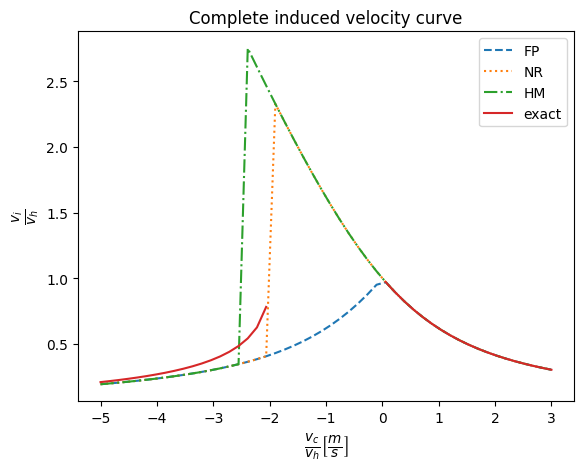

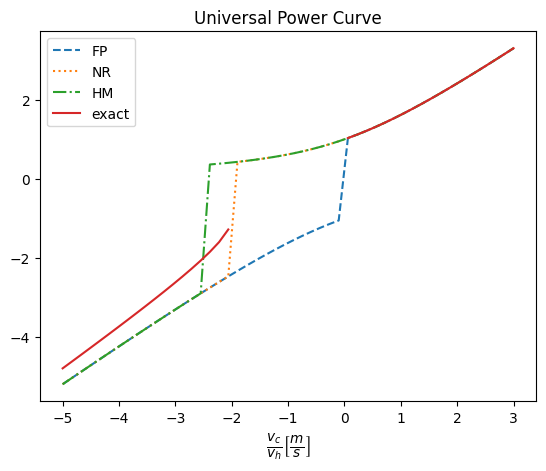

In [15]:
velocity_climb_list = np.linspace(-5*velocity_hover,3*velocity_hover)
exact_inflow_ratio = [AxialAnalyticalRatio(i/velocity_hover) for i in velocity_climb_list]
FP_inflow_ratio = [abs(FixedPointClimb(inflow_hover, i/velocity_tip(edm.Density(0)))['lambda_i+1'][-1]/inflow_hover - i/velocity_hover) for i in velocity_climb_list]
NR_inflow_ratio = [abs(NewtonRaphsonClimb(inflow_hover, i/velocity_tip(edm.Density(0)))['lambda_i+1'][-1]/inflow_hover - i/velocity_hover) for i in velocity_climb_list]
HM_inflow_ratio = [abs(HalleysMethodClimb(inflow_hover, i/velocity_tip(edm.Density(0)))['lambda_i+1'][-1]/inflow_hover - i/velocity_hover) for i in velocity_climb_list]
exact_power_ratio = [AxialPowerRatio(i/velocity_hover) for i in velocity_climb_list]
FP_power_ratio = [(FixedPointClimb(inflow_hover, i/velocity_tip(edm.Density(0)))['lambda_i+1'][-1]/inflow_hover) for i in velocity_climb_list]
NR_power_ratio = [(NewtonRaphsonClimb(inflow_hover, i/velocity_tip(edm.Density(0)))['lambda_i+1'][-1]/inflow_hover) for i in velocity_climb_list]
HM_power_ratio = [(HalleysMethodClimb(inflow_hover, i/velocity_tip(edm.Density(0)))['lambda_i+1'][-1]/inflow_hover) for i in velocity_climb_list]
plt.plot(velocity_climb_list/velocity_hover,FP_inflow_ratio,label='FP',linestyle='--')
plt.plot(velocity_climb_list/velocity_hover,NR_inflow_ratio,label='NR',linestyle=':')
plt.plot(velocity_climb_list/velocity_hover,HM_inflow_ratio,label='HM',linestyle='-.')
plt.plot(velocity_climb_list/velocity_hover,exact_inflow_ratio,label='exact')
plt.title('Complete induced velocity curve')
plt.xlabel(r'$\frac{v_c}{v_h} \left[\frac{m}{s}\right] $',fontsize=14)
plt.ylabel(r'$\frac{v_i}{v_h}$',fontsize=14)
plt.legend()
plt.show()
plt.plot(velocity_climb_list/velocity_hover,FP_power_ratio,label='FP',linestyle="--")
plt.plot(velocity_climb_list/velocity_hover,NR_power_ratio,label='NR',linestyle=":")
plt.plot(velocity_climb_list/velocity_hover,HM_power_ratio,label='HM',linestyle="-.")
plt.plot(velocity_climb_list/velocity_hover,exact_power_ratio,label='exact')
plt.title('Universal Power Curve')
plt.legend()
plt.xlabel(r'$\frac{v_c}{v_h} \left[\frac{m}{s}\right] $',fontsize=14)
plt.show()